# SemEval 2024 Task 2: Safe Biomedical Natural Language Inference for Clinical Trials

----------------

In [1]:
# Könyvtárak telepítése (ha még nem telepítetted)
!pip install --quiet transformers datasets torch scikit-learn pandas tqdm
!pip install -U transformers

# Adatok klónozása és kicsomagolása (egyszeri lépés)
!git clone https://github.com/ai-systems/Task-2-SemEval-2024.git

!unzip -q /content/Task-2-SemEval-2024/training_data.zip -d /content/Task-2-SemEval-2024/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
Cloning into 'Task-2-SemEval-2024'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 58 (delta 22), re

In [2]:
import transformers
print(transformers.__version__)

4.52.4


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

import torch
import accelerate
import transformers

print(torch.__version__)
print(accelerate.__version__)
print(transformers.__version__)

CUDA available: True
GPU: NVIDIA GeForce RTX 2070
2.7.1+cu118
1.7.0
4.52.4


In [3]:
import os
import json
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer
import torch

# DATA_DIR = "/content/Task-2-SemEval-2024"
DATA_DIR = "Task-2-SemEval-2024"
TRAIN_PATH = f"{DATA_DIR}/train.json"
DEV_PATH = f"{DATA_DIR}/dev.json"
TEST_PATH = f"{DATA_DIR}/test.json"
CTRS_DIR = f"{DATA_DIR}/CT json"  # CTR fájlok könyvtára
# DEV_PATH = "/content/Task-2-SemEval-2024/dev.json"
DEV_PATH = "Task-2-SemEval-2024/dev.json"

# Modell neve (cserélhető pl. 'emilyalsentzer/Bio_ClinicalBERT')
# MODEL_NAME = "bert-base-uncased"
# MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
# MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
# MODEL_NAME = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"


# Kétosztályos címkézés beállítása
label2id = {"Entailment": 0, "Contradiction": 1}
id2label = {0: "Entailment", 1: "Contradiction"}

In [4]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# Betöltés
train_dict = load_json(TRAIN_PATH)
dev_dict = load_json(DEV_PATH)
test_dict = load_json(TEST_PATH)

# Átalakítás lista formátumra, ID-k hozzáadása
def dict_to_list(data_dict):
    data_list = []
    for ex_id, ex in data_dict.items():
        ex["id"] = ex_id
        data_list.append(ex)
    return data_list

train_data = dict_to_list(train_dict)
dev_data = dict_to_list(dev_dict)
test_data = dict_to_list(test_dict)

In [5]:
def process_examples(data_list, ctr_dir):
    processed = []
    for ex in tqdm(data_list):
        ctr_id = ex["Primary_id"]
        section = ex["Section_id"]
        hypothesis = ex["Statement"]
        label = ex.get("Label")

        ctr_file = os.path.join(ctr_dir, f"{ctr_id}.json")
        if not os.path.isfile(ctr_file):
            print(f"WARNING: CTR file not found: {ctr_file}")
            continue

        with open(ctr_file, "r", encoding="utf-8") as f:
            ctr = json.load(f)

        if section not in ctr:
            print(f"WARNING: section '{section}' not found in CTR {ctr_id}")
            continue

        section_content = ctr[section]
        premise_text = "\n".join(section_content) if isinstance(section_content, list) else str(section_content)

        input_text = f"[{section}] {premise_text.strip()}\nHypothesis: {hypothesis.strip()}"

        processed.append({
            "id": ex["id"],
            "ctr_id": ctr_id,
            "section": section,
            "hypothesis": hypothesis,
            "label": label,
            "input_text": input_text
        })
    return pd.DataFrame(processed)

# Feldolgozás
df_train = process_examples(train_data, CTRS_DIR)
df_dev = process_examples(dev_data, CTRS_DIR)
df_test = process_examples(test_data, CTRS_DIR)

100%|██████████| 5500/5500 [00:00<00:00, 7588.69it/s]


In [6]:
# Mentés CSV-be, ha szükséges
df_train.to_csv("processed_train.csv", index=False)
df_dev.to_csv("processed_dev.csv", index=False)
df_test.to_csv("processed_test.csv", index=False)

# HuggingFace Dataset objektumok létrehozása
dataset_train = Dataset.from_pandas(df_train)
dataset_dev = Dataset.from_pandas(df_dev)
dataset_test = Dataset.from_pandas(df_test)

In [7]:
# Tokenizer és modell betöltése
# ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # 2 label: Entailment, Contradiction

# GPU beállítása (ha elérhető)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
# Címkék számokká konvertálása
# ---
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

dataset_train = dataset_train.map(encode_labels)

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

In [9]:
def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_train = dataset_train.map(tokenize_function, batched=True)

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

In [10]:
tokenized_train = tokenized_train.train_test_split(test_size=0.1)
train_dataset = tokenized_train["train"]
eval_dataset = tokenized_train["test"]

In [11]:
# dev_dict betöltése
with open(DEV_PATH, "r", encoding="utf-8") as f:
    dev_dict = json.load(f)

# Átalakítás listává
dev_data = []
for ex_id, ex in dev_dict.items():
    ex["id"] = ex_id
    dev_data.append(ex)

In [12]:

df_dev = process_examples(dev_data, CTRS_DIR)
dataset_dev = Dataset.from_pandas(df_dev)
dataset_dev = dataset_dev.map(encode_labels)
tokenized_dev = dataset_dev.map(tokenize_function, batched=True)

train_dataset = tokenized_train
eval_dataset = tokenized_dev

100%|██████████| 200/200 [00:00<00:00, 9520.72it/s]


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [13]:
training_args = TrainingArguments(
    output_dir="/content/bert-semeval-results",
    eval_strategy="epoch",  # ← ***
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="/content/logs",
    logging_steps=50,
    report_to=[]  # kikapcsolja az összes külső riportáló rendszert (beleértve a wandb-t),
)

In [14]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [15]:
train_dataset = tokenized_train["train"]
# eval_dataset = tokenized_train["test"]
eval_dataset = tokenized_dev

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-15-c7145b7c2679>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.704500,0.692495,0.525000,0.460825
2,0.701200,0.691867,0.535000,0.534430
3,0.696000,0.691752,0.520000,0.517636


TrainOutput(global_step=288, training_loss=0.698857929971483, metrics={'train_runtime': 500.6262, 'train_samples_per_second': 9.169, 'train_steps_per_second': 0.575, 'total_flos': 1207679744102400.0, 'train_loss': 0.698857929971483, 'epoch': 3.0})

In [17]:
# Tokenizált tesztadat újragenerálása, ha szükséges
tokenized_test = dataset_test.map(tokenize_function, batched=True)

# A label mező eltávolítása (mivel a teszt set nem tartalmaz címkéket)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [18]:
predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_classes = [id2label[p] for p in predicted_labels]

# Mentés CSV-be
df_preds = df_test.copy()
df_preds["predicted_label"] = predicted_classes
df_preds[["id", "predicted_label"]].to_csv("test_predictions.csv", index=False)

In [19]:
trainer.evaluate(eval_dataset=tokenized_dev)

{'eval_loss': 0.6918673515319824,
 'eval_accuracy': 0.535,
 'eval_f1_macro': 0.534429676353533,
 'eval_runtime': 6.2119,
 'eval_samples_per_second': 32.196,
 'eval_steps_per_second': 2.093,
 'epoch': 3.0}

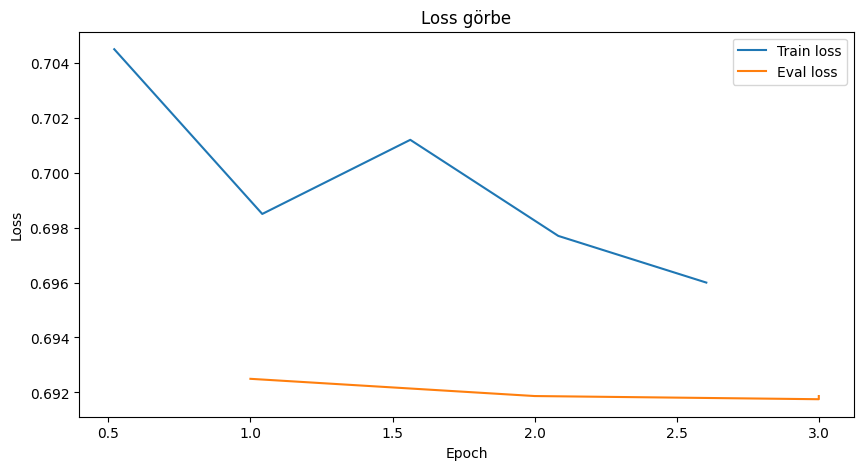

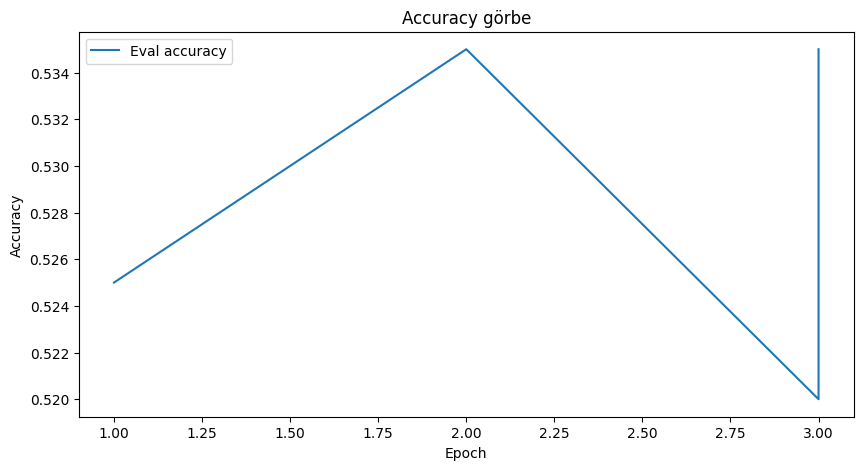

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# A Trainer log fájl elérési útja
log_path = "./content/logs/events.out.tfevents.*"

# Alternatív: ha a Trainer history-t elmented, pl. trainer.state.log_history
history = trainer.state.log_history

# Loss és accuracy kigyűjtése
train_loss = [x["loss"] for x in history if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
epochs = [x["epoch"] for x in history if "loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in history if "eval_loss" in x]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(eval_epochs, eval_loss, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss görbe")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(eval_epochs, eval_acc, label="Eval accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy görbe")
plt.show()

In [21]:
# ne fuss le

save_dir = "Results/dmis-lab-biobert-base-cased-v1.1_2"
os.makedirs(save_dir, exist_ok=True)

# Modell és tokenizer mentése
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Trainer log_history mentése
import json
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, ensure_ascii=False, indent=2)

# Loss/accuracy görbék mentése képként
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_loss = [x["loss"] for x in history if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
epochs = [x["epoch"] for x in history if "loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in history if "eval_loss" in x]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(eval_epochs, eval_loss, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss görbe")
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(10,5))
plt.plot(eval_epochs, eval_acc, label="Eval accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy görbe")
plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
plt.close()

# Predikciók mentése (ha van)
if "predicted_classes" in locals():
    df_preds.to_csv(os.path.join(save_dir, "test_predictions.csv"), index=False)


Lementett modell visszatöltése

In [22]:
# ne fuss le

from transformers import AutoModelForSequenceClassification, AutoTokenizer

load_dir = "Results/dmis-lab-biobert-base-cased-v1.1_2"
model = AutoModelForSequenceClassification.from_pretrained(load_dir)
tokenizer = AutoTokenizer.from_pretrained(load_dir)

import shutil

# Forrás: a mentett modell mappájában lévő predikciós CSV
src = f"{load_dir}/test_predictions.csv"
# Cél: a projekt gyökérkönyvtára
dst = "test_predictions.csv"

shutil.copyfile(src, dst)
print("Predikciós fájl átmásolva:", dst)

from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # ugyanaz a függvény, mint tanításkor
)

Predikciós fájl átmásolva: test_predictions.csv


<ipython-input-22-1115addae696>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
# ne fuss le
import pandas as pd

# Értékelés a dev adathalmazon
results = trainer.evaluate(eval_dataset=tokenized_dev)
# Eredmények DataFrame-be rendezése és szebb kiírása
results_df = pd.DataFrame([results])
display(results_df)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [24]:
import pandas as pd
import json
from sklearn.metrics import accuracy_score, f1_score

# Predikciók betöltése
df_preds = pd.read_csv("test_predictions.csv")  # Ez tartalmazza az id és predicted_label oszlopokat

# Gold címkék betöltése
with open("Task-2-SemEval-2024/gold_test.json", "r", encoding="utf-8") as f:
    gold_dict = json.load(f)

gold_data = []
for ex_id, ex in gold_dict.items():
    gold_data.append({
        "id": ex_id,
        "gold_label": ex["Label"]
    })
df_gold = pd.DataFrame(gold_data)

# Predikciók és gold címkék összefésülése
df_merged = pd.merge(df_preds, df_gold, on="id")

label2id = {"Entailment": 0, "Contradiction": 1}
y_true = df_merged["gold_label"].map(label2id)
y_pred = df_merged["predicted_label"].map(label2id)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Test accuracy: {accuracy:.4f}")
print(f"Test macro F1-score: {f1:.4f}")

Test accuracy: 0.5011
Test macro F1-score: 0.4850


In [ ]:
# Kiüríti a GPU memóriát

import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()